# Rotterdam stylized case

In [1]:
from classes import *
import copy
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import pickle
import tqdm


from models import Rotty
from mayors import *

### Load the model with parameters

In [2]:
Rotty

Rotty 
-----------
allFloodProtection: 
No 3.5; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)]), 'I_experience_interp': {'xp': [0, 0.5], 'fp': [0, 1]}, 'I_social': 1}

### Load storm surge scenarios

In [3]:
# Load all SLR_Scenario
allSLR_Scenario = SLR_Scenario_from_pickles(Path('SLR_projections','Transients'))

# Load all SurgeHeight (Realisations of extreme value distribution)
for filename in Path('SurgeHeight','biased_from_five_hundred').glob('*.csv'):
    obj = SurgeHeight(filename.stem) #Init object with name derived from filename
    obj.from_csv(filename) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in allSLR_Scenario:
    for SurgeHeight in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SurgeHeight)
        
# Print all available SLR scenarios
for SLR_Scenario in allSLR_Scenario:
    print(SLR_Scenario.name,end=' ||| ')

Scenario_01 ||| Scenario_02 ||| Scenario_03 ||| Scenario_04 ||| Scenario_05 ||| Scenario_06 ||| Scenario_07 ||| Scenario_08 ||| Scenario_09 ||| 

In [4]:
#list(Path('SurgeHeight','biased_from_five_hundred').glob('*.csv'))

### Run this block if you want to focus on a subset of the scenarios

In [5]:
# Make a manual preselection of scenarios to simplify plots
transient = "five_hundred_8"
selection = [x for x in allSurgeLevel if x.name.split("__")[1] == transient] #only run experiments for one of the transients
#selection = allSurgeLevel
selected_scens = ['01','03','05','09']
#selection = [x for x in selection if x.name.split('__')[0] in ['SROCC_2019_RCP26_17','SROCC_2019_RCP85_50','SROCC_2019_RCP85_83','Bamber_2019_high_95']]
selection =  [x for x in selection if x.name.split('__')[0].split('_')[1] in selected_scens]
len(selection)

4

### Load adaptation strategies (Mayors)

In [6]:
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

### Select implementation times of measures

In [7]:
Implementation_times = [ #small measure, large measure
    (4,6),
    (5,7),
    (6,9), 
    (7,10), #default
    (8,11),
    (9,13),
    (10,14),
    (11,16),
    (12,17),
    (13,19),
    (14,20)]

In [8]:
it_sel = 3 #select the it_pairs from the list

In [9]:
Implementation_times[it_sel]

(7, 10)

### Model run algorithm

In [10]:
from run_model import run_model01

### Run the behaviour of one Mayor

In [11]:
#run one mayor:
experiments = []
for SurgeLevel in selection:
    experiment = run_model01(Rotty,SurgeLevel,Sentiment(),Implementation_times[it_sel],do_print=True)
    experiments.append(experiment)
print('experiments finished')

Finished experiment Rotty_Scenario_01__five_hundred_8_Sentiment_(7, 10) 2021/03/11, 13:22:58
Finished experiment Rotty_Scenario_03__five_hundred_8_Sentiment_(7, 10) 2021/03/11, 13:22:59
Finished experiment Rotty_Scenario_05__five_hundred_8_Sentiment_(7, 10) 2021/03/11, 13:22:59
Finished experiment Rotty_Scenario_09__five_hundred_8_Sentiment_(7, 10) 2021/03/11, 13:22:59
experiments finished


### Plot the results

In [12]:
from matplotlib.lines import Line2D

Sentiment_trans_five_hundred_8_it_(7, 10)
Target folder Visualisations\2021_3_11 already exists


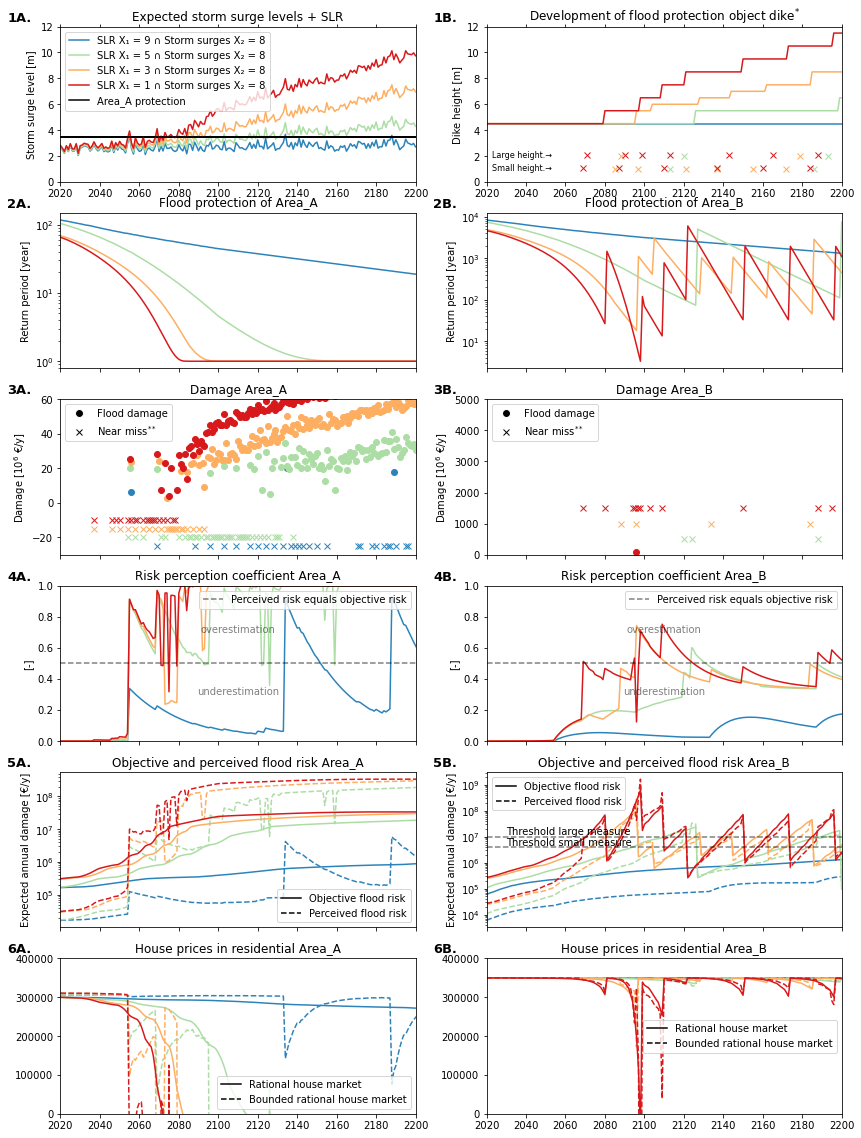

In [13]:
p1 = ['#e66101','#fdb863','#b2abd2','#5e3c99'] #palette
p2 = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']
p3 = ['#d7191c','#fdae61','#abdda4','#2b83ba']
p = p3
p.reverse()

nrows=6
ncols=2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=False,sharex=True,figsize=(14,20))

handles00 = []


xlim = (2020,2200)


for j,experiment in enumerate(reversed(experiments)):
    
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor
    
    time = SurgeLevel.years
    
    axes[0,0].plot(time,SurgeLevel.surgelevel,color=p[j])

    #labels.append(SurgeLevel.name)
    labelSLR = SurgeLevel.corresponding_SLR_Scenario.name.split('_')[1][-1]
    labelSH = SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1]
    label = 'SLR X{} = '.format(u'\u2081') + labelSLR + ' {} Storm surges X{} = '.format(u"\u2229",u'\u2082') + labelSH
    handles00.append(Line2D([0], [0], color=p[j], label=label,linestyle='-'))

    axes[0,0].set_title('Expected storm surge levels + SLR')
    #axes[0,0].set_xlabel('Time [year]')
    axes[0,0].set_ylabel('Storm surge level [m]')
    axes[0,0].set_ylim(0,12)
    axes[0,1].set_ylim(0,12)
    axes[0,1].set_ylabel('Dike height [m]')
    
    axes[0,0].set_xlim(xlim[0],xlim[1])
    
    #PLOT THE HISTORY OF THE MEASURES
    #axes[0,1].plot(time,Model.allFloodProtection[1].measure_history,'x',color=p[j]) #PLOT THE HISTORY OF THE MEASURES
    y_offset = 0.05
    
    mh = [m for m in Model.allFloodProtection[1].measure_history]
    mh = [None if m == 0 else (2*m)+(j-1.5)*y_offset for m in mh]
    axes[0,1].plot(time,mh,'x',color=p[j]) #PLOT THE HISTORY OF THE MEASURES
    
    
    for i, Area in enumerate(Model.allResidentialArea):
        axes[0,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
       
        
        axes[1,i].set_title('Flood protection of {}'.format(Model.allResidentialArea[i].name))
        axes[1,i].plot(time,Model.allResidentialArea[i].protection_level_rp,'-',color=p[j])
        axes[1,i].set_yscale("log")
        axes[1,i].set_ylabel('Return period [year]')
        #axes[1,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        
        #plot damage
        axes[2,i].set_title('Damage {}'.format(Area.name))
        #axes[2,i].plot(time,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o',color=p[j])
        #Slightly offset values to make it more visible
        offset_x = 0
        offset_y = 0
        if Area.name == 'Area_A' and j%2 == 0: 
            offset_x = 1
            offset_y = 0
        axes[2][i].plot(np.array(time)+offset_x, \
                        np.array([x*10**(-6) for x in Model.allResidentialArea[i].flood_damage])+offset_y,'o',color=p[j],markersize=6)
        
        axes[2,i].set_ylabel('Damage [10$^6$ \u20ac/y]')
        #axes[2,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    

    
        axes[3,i].set_title('Risk perception coefficient {}'.format(Model.allResidentialArea[i].name))
        axes[3,i].plot(time,Model.allResidentialArea[i].risk_perception,'-',color=p[j])
        axes[3,i].set_ylabel('[-]')
        axes[3,i].set_ylim(0,1)

        #axes[3,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        
        axes[4,i].set_title('Objective and perceived flood risk {}'.format(Model.allResidentialArea[i].name))
        unit_corr = [x * 10**6 for x in Model.allResidentialArea[i].risk]
        axes[4,i].plot(time,unit_corr,'-',color=p[j])
        axes[4,i].set_yscale("log")
        axes[4,i].set_ylabel('Expected annual damage [\u20ac/y]')
        #axes[4,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        #Manually add legend patches
        custom_lines = [Line2D([0], [0], color='black',label='Objective flood risk',linestyle='-'),
                        Line2D([0], [0], color='black',label='Perceived flood risk',linestyle='--')]
        axes[4,i].legend(handles=custom_lines)
        
        unit_corr2 = [x * 10**6 for x in Model.allResidentialArea[i].risk_perceived]
        axes[4,i].plot(time,unit_corr2,'--',color=p[j])
        
        axes[5,i].set_title('House prices in residential {}'.format(Model.allResidentialArea[i].name))
        axes[5,i].plot(time,Area.house_price_t_objective,color=p[j])
        custom_lines = [Line2D([0], [0], color='black',label='Rational house market',linestyle='-'),
                        Line2D([0], [0], color='black',label='Bounded rational house market',linestyle='--')]
        axes[5,i].legend(handles=custom_lines)
        axes[5,i].set_ylim(0,4e5)
        
        
        
        axes[5,i].plot(time,Area.house_price_t_subjective,'--',color=p[j])
        
        #axes[6,i].set_title('Development of trust in {} [DEPRECIATED]'.format(Area.name))
        #axes[6,i].plot(time,Model.allResidentialArea[i].trust_t,color=p[j])
        #axes[6,i].set_ylim(0,100)
    
    #Plot dike heights
    baselevel = Model.allFloodProtection[0].baseline_level
    axes[0,0].plot([2020,2200],[baselevel,baselevel],color='black')
    
    axes[0,1].plot(time,Model.allFloodProtection[1].protection_level,color=p[j])
    axes[0,1].set_title('Development of flood protection object dike$^{*}$')
    
       
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[2][0].set_ylim(-30,60)
    HP = Model.allResidentialArea[0]
    temp = [-25 + 5*j if x=='!' else None for x in HP.event_history]
    axes[2][0].plot(time,temp,'x',color=p[j],markersize=6)
            
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[2][1].set_ylim(0,5000)
    CC = Model.allResidentialArea[1]
    temp = [0 + 500*j if x=='!' else None for x in CC.event_history]
    axes[2][1].plot(time,temp,'x',color=p[j],markersize=6)
    
    handles2 = [Line2D([0], [0], marker='o', color='w', label='Flood damage', markerfacecolor='black', markersize=8),
             Line2D([0], [0], marker='x', color='w', label='Near miss$^{**}$', markeredgecolor='black', markersize=6)]
    axes[2,0].legend(handles=handles2,loc='upper left')
    axes[2,1].legend(handles=handles2,loc='upper left')

    
handles00.append(Line2D([0], [0], color='black', label='Area_A protection',linestyle='-'))
axes[0,0].legend(handles=handles00)

axes[0,1].text(2023,0.9,'Small height.' + u"\u2192",fontsize=8)
axes[0,1].text(2023,1.9,'Large height.' + u"\u2192",fontsize=8)
#axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)


############### PRINT MAYOR-SPECIFIC THRESHOLDS ####################
if Mayor.get_name() == 'Lawkeeper':
    axes[1,1].plot(time,[Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[1,1].plot(time,[Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[1,1].text(2030,Mayor.threshold_small - 4000,'Threshold small measure',color='black',alpha=1)
    axes[1,1].text(2030,Mayor.threshold_large - 800,'Threshold large measure',color='black',alpha=1)
    
if Mayor.get_name() == 'H. Economicus' or Mayor.get_name() == 'Sentiment':
    axes[4,1].plot(time,[(10**6)*Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[4,1].plot(time,[(10**6)*Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[4,1].text(2030,(10**6)*Mayor.threshold_small+0.4E6,'Threshold small measure',color='black',alpha=1)
    axes[4,1].text(2030,(10**6)*Mayor.threshold_large+2E6,'Threshold large measure',color='black',alpha=1)
    
###################################################################

    
for j in [0,1]:
    alpha = 0.5
    color = 'black'
    axes[3,j].plot(time,[0.5]*len(time),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[3,j].legend(handles=custom_line)
    axes[3,j].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')
    axes[3,j].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')


for nr in range(0,nrows):
    for l,letter in enumerate(('A','B')):
        axes[nr,l].text(-0.15, 1.1, "{}{}.".format(nr+1,letter), transform=axes[nr,l].transAxes,
                       fontsize=13, fontweight='bold', va='top')
    
#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################

its = Implementation_times[it_sel]
filename = experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1] + "_it_" + str(its)
print(filename)

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations',date)
if not Path.exists(target): target.mkdir()
else: print("Target folder {} already exists".format(target))


In [14]:
#fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)

# Explore tipping points

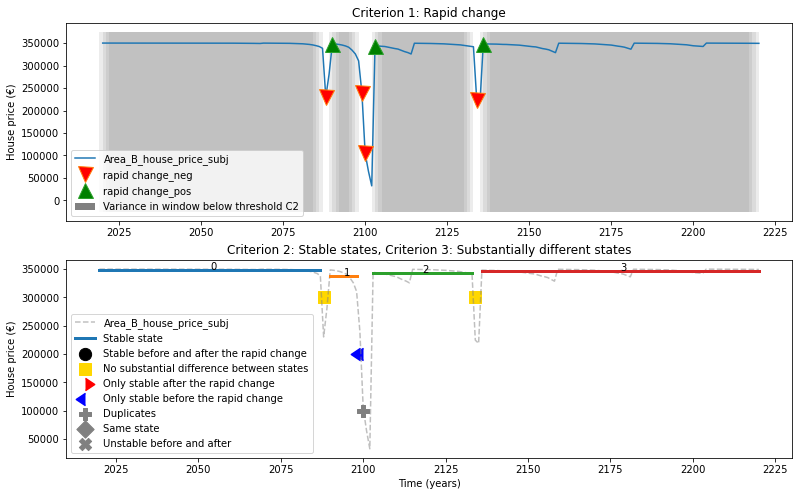

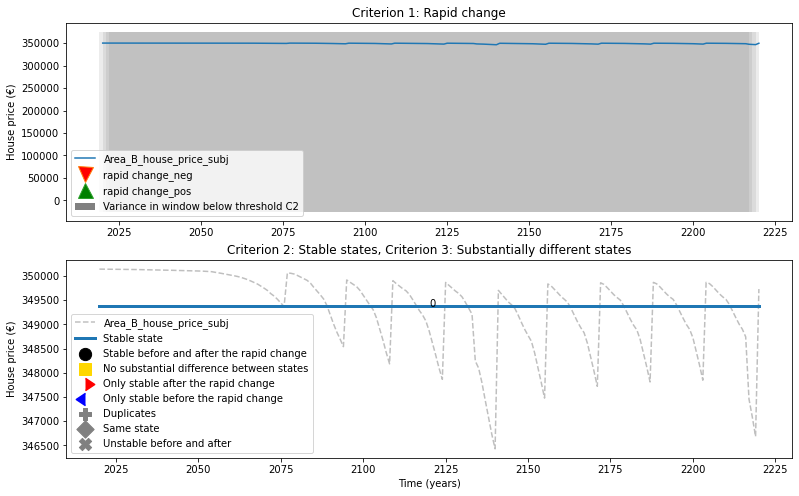

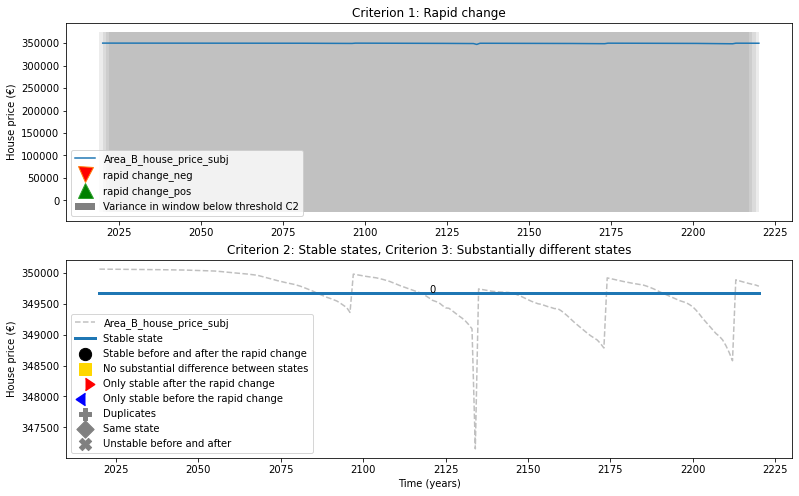

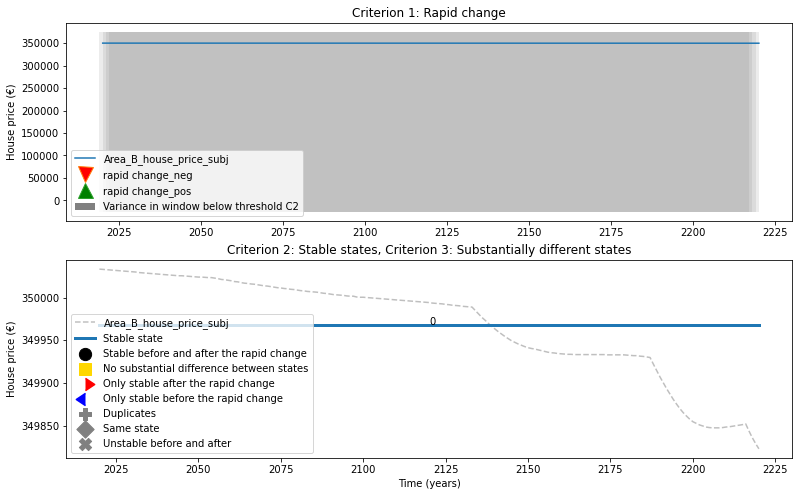

In [20]:

for experiment in experiments:
    experiment.create_Metrics()
    M = experiment.allMetrics[3]
    M.create_statistics(window=4)
    M.find_SETP_candidates(c1=0.15,c2=1e9,c3=10, margin=2)
    M.select_SETPs(sign=-1)
    M.plot_SETPs(figsize=(13,8))
    
    